This notebook is for removing labels that are not isntances of center pivots. Inputs to the model weill be the full size images and we will use the crop setting in config to pass smaller input sof a fixed size to the model for training. We can then use the adaptable grid notebook for detection testing to generate full gridded image chips

In [1]:
import random
import os
import shutil
import copy
from skimage import measure
from skimage import morphology as skim
import skimage.io as skio
import warnings
import pandas as pd
import numpy as np

ROOT_DIR = os.path.abspath("../")
DATASET_DIR = os.path.join(ROOT_DIR, 'data/raw/wv2')
REORDER_DIR = os.path.join(DATASET_DIR, 'reordered_tifs')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
WV2_DIR = os.path.join(DATASET_DIR, 'center_pivot_tifs')
LABELS_DIR = os.path.join(DATASET_DIR, 'center_pivot_labels')
CONNECTED_COMP_DIR = os.path.join(DATASET_DIR, 'connected_comp_labels')
OPENED_LABELS_DIR = os.path.join(DATASET_DIR, 'opened_labels')
OUT_WV2_DIR = os.path.join(DATASET_DIR, 'adjusted_gridded_tifs')
OUT_LABELS_DIR = os.path.join(DATASET_DIR, 'adjusted_gridded_labels')

# Results directory
# Save submission files and test/train split csvs here
RESULTS_DIR = os.path.join(ROOT_DIR, "results/wv2/") 



In [2]:
from affine import Affine
import mercantile

import rasterio
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
import os
import random
random.seed(4)
gs_list = sorted(next(os.walk(WV2_DIR))[2])
label_list = sorted(next(os.walk(LABELS_DIR))[2])
assert skio.imread(os.path.join(WV2_DIR,gs_list[0])).shape[-1] == 8

In [3]:
import os, gdal, rasterio

def rm_mostly_empty(scene_path, label_path):
    '''
    Removes a grid that is mostly (over 1/4th) empty
    '''
    with rasterio.open(scene_path) as src:
        pixel_count = src.width * src.height
        mask = src.dataset_mask()
        nodata_pixel_count = (mask == 0).sum()
        print('nodata count',nodata_pixel_count)
        print('pixel count',pixel_count)
        if nodata_pixel_count/pixel_count > .75:
            os.remove(scene_path)
            os.remove(label_path)
            print('removed scene and label')

for gs, label in zip(gs_list, label_list):
    gs_path = os.path.join(WV2_DIR,gs)
    label_path = os.path.join(LABELS_DIR,label)
    #assign unique name to each gridded tif, keeping season suffix
    #assigning int of same length as ZA0932324 naming convention

    tile_size_x = 1024
    tile_size_y = 1024

    ds_gs = gdal.Open(gs_path)
    band_gs = ds_gs.GetRasterBand(1)
    xsize_gs = band_gs.XSize
    ysize_gs = band_gs.YSize   
    
    ds_label = gdal.Open(label_path)
    band_label = ds_label.GetRasterBand(1)


    for i in range(0, xsize_gs, tile_size_x):
        for j in range(0, ysize_gs, tile_size_y):
            unique_id = str(random.randint(100000000,999999999))
            out_path_gs = os.path.join(OUT_WV2_DIR,unique_id)+gs[2:]
            out_path_label = os.path.join(OUT_LABELS_DIR,unique_id)+label[2:]
            com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(gs_path) + " " + str(out_path_gs)
            os.system(com_string)
            com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(label_path) + " " + str(out_path_label)
            os.system(com_string)
            rm_mostly_empty(out_path_gs, out_path_label)
            

nodata count 20235
pixel count 1048576
nodata count 6928
pixel count 1048576
nodata count 809986
pixel count 1048576
removed scene and label
nodata count 11406
pixel count 1048576
nodata count 0
pixel count 1048576
nodata count 802085
pixel count 1048576
removed scene and label
nodata count 556828
pixel count 1048576
nodata count 557801
pixel count 1048576
nodata count 931964
pixel count 1048576
removed scene and label
nodata count 21027
pixel count 1048576
nodata count 7198
pixel count 1048576
nodata count 814417
pixel count 1048576
removed scene and label
nodata count 11802
pixel count 1048576
nodata count 0
pixel count 1048576
nodata count 806224
pixel count 1048576
removed scene and label
nodata count 552141
pixel count 1048576
nodata count 553139
pixel count 1048576
nodata count 932729
pixel count 1048576
removed scene and label
nodata count 1024
pixel count 1048576
nodata count 243
pixel count 1048576
nodata count 814698
pixel count 1048576
removed scene and label
nodata count 46

In [23]:

def preprocess():
    
    def remove_dir_folders(directory):
        '''
        Removes all files and sub-folders in a folder and keeps the folder.
        '''
    
        folderlist = [ f for f in os.listdir(directory)]
        for f in folderlist:
            shutil.rmtree(os.path.join(directory,f))

    def load_gs_wv2(image_id, source_dir):
        """Load the specified wv2 os/gs image pairs and return a [H,W,8] 
        Numpy array. Channels are ordered [B, G, R, NIR, B, G, R, NIR], OS 
        first.
        """
        # Load image
        
        gs_path = os.path.join(source_dir,image_id+'_MS_GS.tif')
        arr = skio.imread(gs_path)
        print(arr.shape)
        red = arr[:,:,4]
        blue = arr[:,:,1]
        green = arr[:,:,2]
        color_arr = np.dstack((red, green, blue))
        color_arr[color_arr <= 0]=0
        reorder_path = os.path.join(REORDER_DIR,image_id+'.tif')
        print(color_arr.shape, 'color_arr shape')
        skio.imsave(reorder_path,color_arr, plugin='tifffile')
            
    # all files, including ones we don't care about
    file_ids_all = next(os.walk(OUT_WV2_DIR))[2]
      
    image_ids_gs = [image_id for image_id in file_ids_all if 'GS' in image_id]

    image_ids_short = [image_id[0:9] for image_id in image_ids_gs]

    for imid in image_ids_short:
        load_gs_wv2(imid,OUT_WV2_DIR)

    image_list = next(os.walk(REORDER_DIR))[2]
    
    def move_img_to_folder(filename):
        '''Moves a file with identifier pattern ZA0165086_MS_GS.tif to a 
        folder path ZA0165086/image/ZA0165086_MS_GS.tif
        Also creates a masks folder at ZA0165086/masks'''
        
        folder_name = os.path.join(TRAIN_DIR,filename[:9])
        if os.path.isdir(folder_name):
            shutil.rmtree(folder_name)
        os.mkdir(folder_name)
        new_path = os.path.join(folder_name, 'image')
        mask_path = os.path.join(folder_name, 'masks')
        os.mkdir(new_path)
        file_path = os.path.join(REORDER_DIR,filename)
        os.rename(file_path, os.path.join(new_path, filename))
        os.mkdir(mask_path)

    for img in image_list:
        move_img_to_folder(img)

    label_list = next(os.walk(OUT_LABELS_DIR))[2]

    for name in label_list:
        arr = skio.imread(os.path.join(OUT_LABELS_DIR,name))
        arr[arr == -1.7e+308]=0
        print(arr.shape)
        label_name = name[0:15]+'.tif'
        opened_path = os.path.join(OPENED_LABELS_DIR,name)
        kernel = np.ones((5,5))
        arr = skim.binary_opening(arr, kernel)
        arr=1*arr
        assert arr.ndim == 2
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            skio.imsave(opened_path, 1*arr)

    label_list = next(os.walk(OPENED_LABELS_DIR))[2]

    for name in label_list:
        arr = skio.imread(os.path.join(OPENED_LABELS_DIR,name))
        blob_labels = measure.label(arr, background=0)
        blob_vals = np.unique(blob_labels)
        for blob_val in blob_vals[blob_vals!=0]:
            labels_copy = blob_labels.copy()
            labels_copy[blob_labels!=blob_val] = 0
            labels_copy[blob_labels==blob_val] = 1
            label_name = name[0:15]+str(blob_val)+'.tif'
            label_path = os.path.join(CONNECTED_COMP_DIR,label_name)
            assert labels_copy.ndim == 2
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                print(label_path, 'connected comp prior to move')
                print(labels_copy.shape)
                skio.imsave(label_path, labels_copy)

#     def move_mask_to_folder(filename):
#         '''Moves a mask with identifier pattern ZA0165086_label_1.tif to a 
#         folder path ZA0165086/mask/ZA0165086_label_01.tif. Need to run 
#         connected components first.
#         '''
#         if os.path.isdir(os.path.join(TRAIN_DIR,filename[:9])):
#             folder_path = os.path.join(TRAIN_DIR,filename[:9])
#             mask_path = os.path.join(folder_path, 'masks')
#             file_path = os.path.join(CONNECTED_COMP_DIR,filename)
#             os.rename(file_path, os.path.join(mask_path, filename))

#     mask_list = next(os.walk(CONNECTED_COMP_DIR))[2]
#     for mask in mask_list:
#         move_mask_to_folder(mask)

#     id_list = next(os.walk(TRAIN_DIR))[1]
#     no_field_list = []
#     for fid in id_list:
#         mask_folder = os.path.join(DATASET_DIR,'train',fid, 'masks')
#         if not os.listdir(mask_folder): 
#             no_field_list.append(mask_folder)
#     no_field_frame = pd.DataFrame(no_field_list)
#     no_field_frame.to_csv(os.path.join(DATASET_DIR,'no_field_list.csv'))
    
#     for fid in id_list:
#         mask_folder = os.path.join(DATASET_DIR, 'train',fid, 'masks')
#         im_folder = os.path.join(DATASET_DIR, 'train',fid, 'image')
#         if not os.listdir(mask_folder):
#             im_path = os.path.join(im_folder, os.listdir(im_folder)[0])
#             arr = skio.imread(im_path)
#             mask = np.zeros_like(arr[:,:,0])
#             assert mask.ndim == 2
#             # ignores warning about low contrast image
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore", category=UserWarning)
#                 skio.imsave(os.path.join(mask_folder, fid + '_label_0.tif'),mask)



121278532_MS_GS1.tif
121278532_MS_GS2.tif
163186545_MS_GS1.tif
163186545_MS_GS2.tif
163186545_MS_GS3.tif
163186545_MS_GS4.tif
163186545_MS_GS5.tif
214013443_MS_GS1.tif
214013443_MS_GS2.tif
214013443_MS_GS3.tif
214013443_MS_GS4.tif
266400214_MS_GS1.tif
266400214_MS_GS2.tif
266400214_MS_GS3.tif
285397122_MS_GS1.tif
285397122_MS_GS10.tif
285397122_MS_GS11.tif
285397122_MS_GS12.tif
285397122_MS_GS13.tif
285397122_MS_GS14.tif
285397122_MS_GS15.tif
285397122_MS_GS16.tif
285397122_MS_GS17.tif
285397122_MS_GS18.tif
285397122_MS_GS19.tif
285397122_MS_GS2.tif
285397122_MS_GS20.tif
285397122_MS_GS21.tif


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


285397122_MS_GS22.tif
285397122_MS_GS23.tif
285397122_MS_GS24.tif
285397122_MS_GS25.tif
285397122_MS_GS26.tif
285397122_MS_GS27.tif
285397122_MS_GS28.tif
285397122_MS_GS29.tif
285397122_MS_GS3.tif
285397122_MS_GS30.tif
285397122_MS_GS4.tif
285397122_MS_GS5.tif
285397122_MS_GS6.tif
285397122_MS_GS7.tif
285397122_MS_GS8.tif
285397122_MS_GS9.tif
338293563_MS_GS1.tif
338293563_MS_GS2.tif
338293563_MS_GS3.tif
353454709_MS_GS1.tif
353454709_MS_GS10.tif
353454709_MS_GS11.tif
353454709_MS_GS12.tif
353454709_MS_GS13.tif
353454709_MS_GS14.tif
353454709_MS_GS15.tif
353454709_MS_GS16.tif
353454709_MS_GS17.tif
353454709_MS_GS18.tif
353454709_MS_GS19.tif
353454709_MS_GS2.tif
353454709_MS_GS20.tif
353454709_MS_GS21.tif
353454709_MS_GS22.tif
353454709_MS_GS3.tif
353454709_MS_GS4.tif
353454709_MS_GS5.tif
353454709_MS_GS6.tif
353454709_MS_GS7.tif
353454709_MS_GS8.tif
353454709_MS_GS9.tif
381019256_MS_GS1.tif
381019256_MS_GS10.tif
381019256_MS_GS11.tif
381019256_MS_GS12.tif
381019256_MS_GS13.tif
38101925

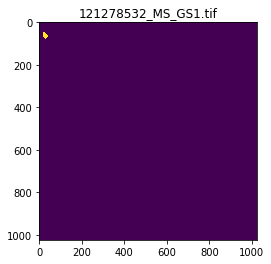

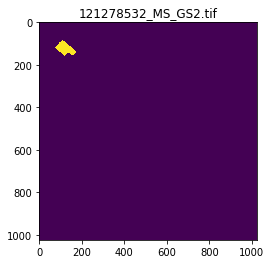

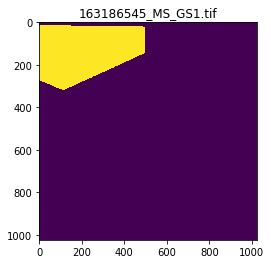

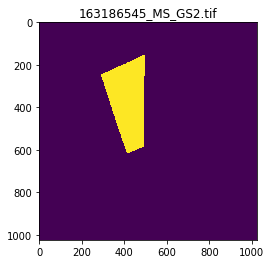

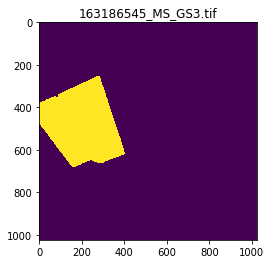

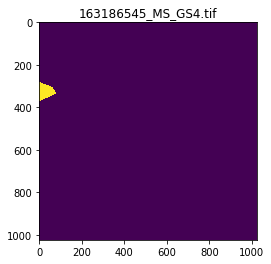

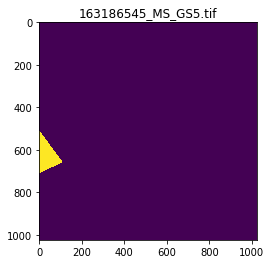

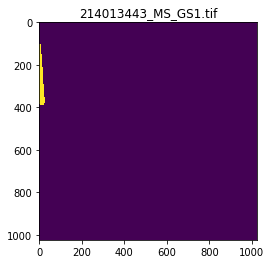

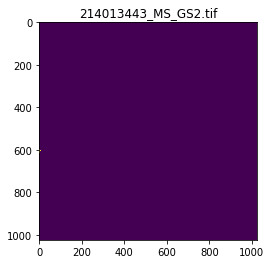

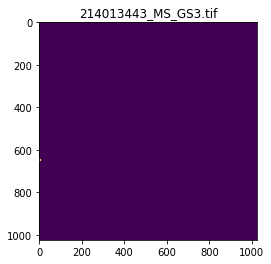

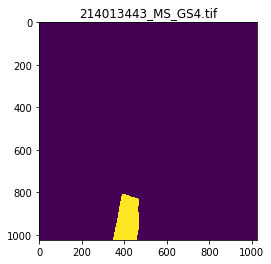

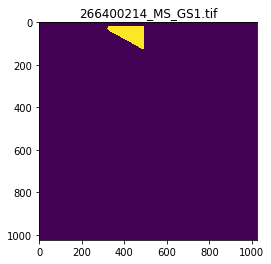

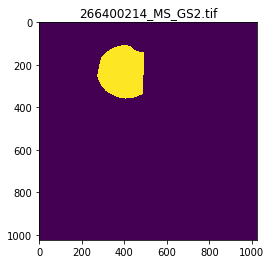

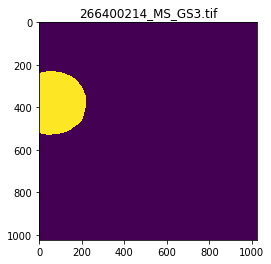

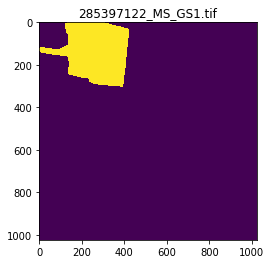

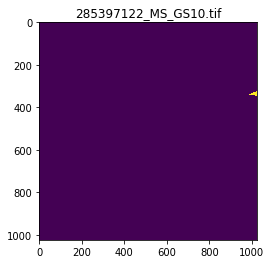

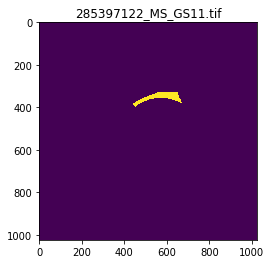

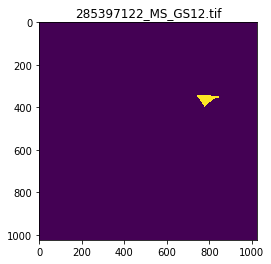

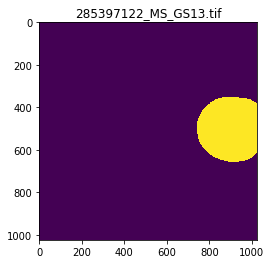

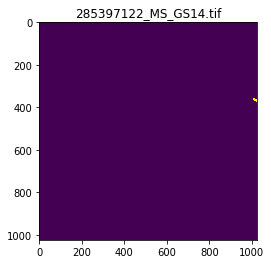

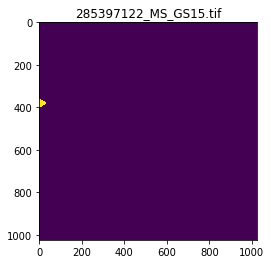

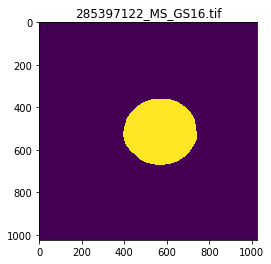

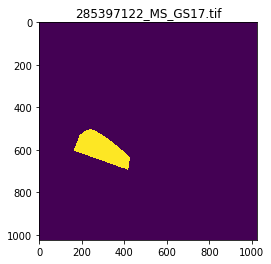

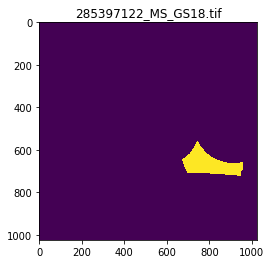

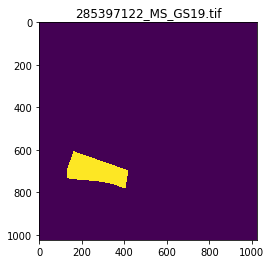

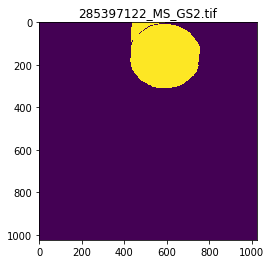

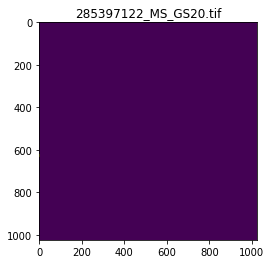

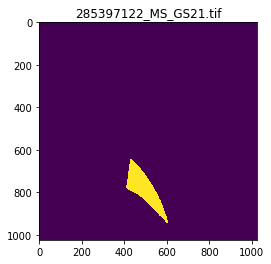

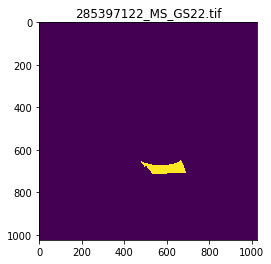

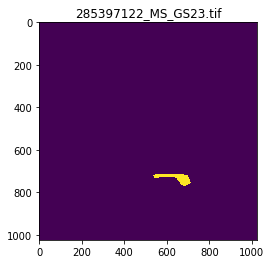

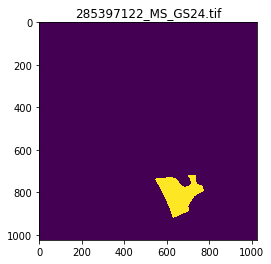

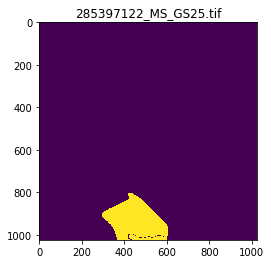

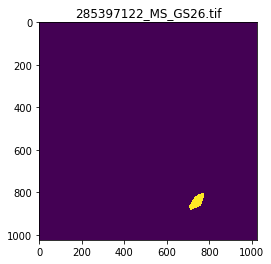

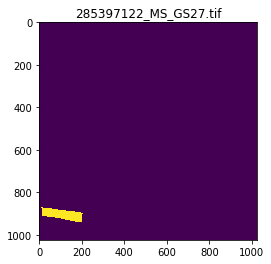

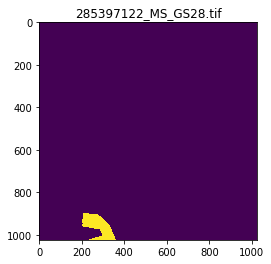

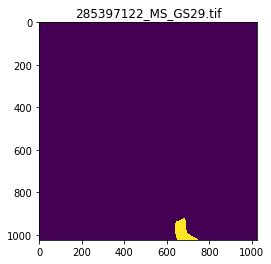

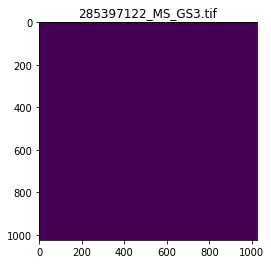

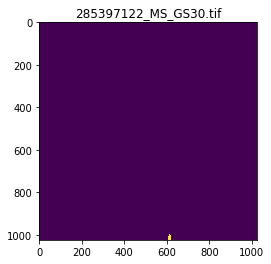

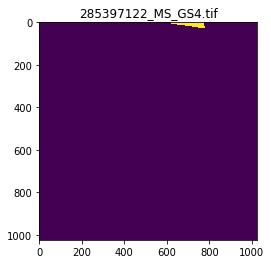

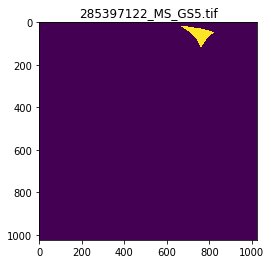

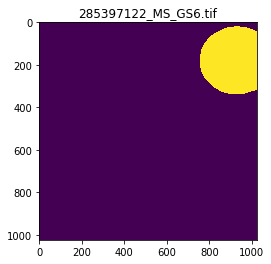

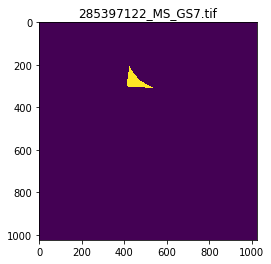

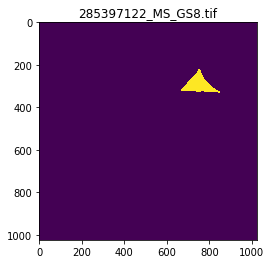

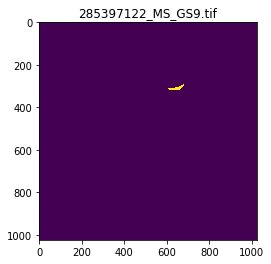

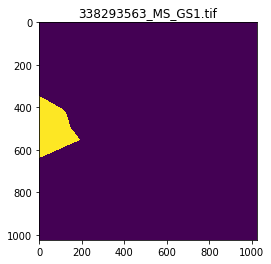

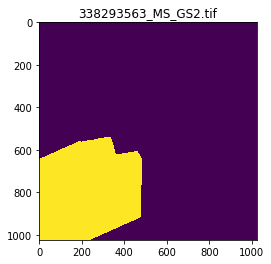

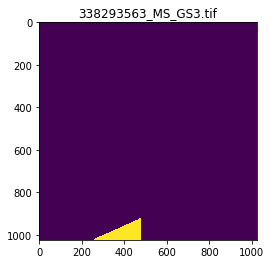

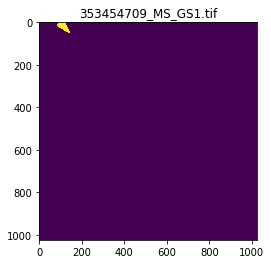

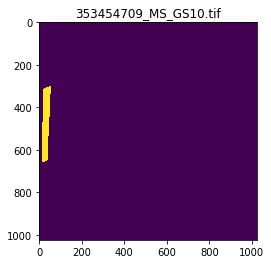

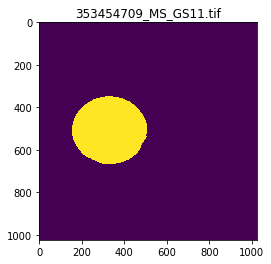

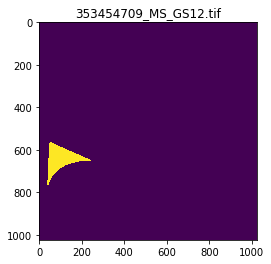

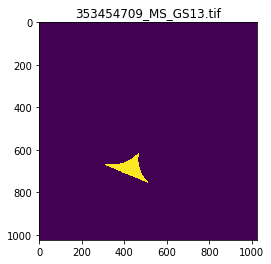

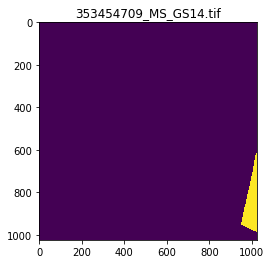

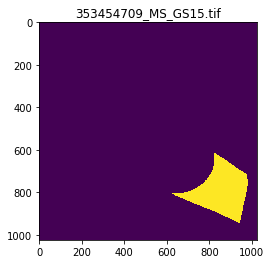

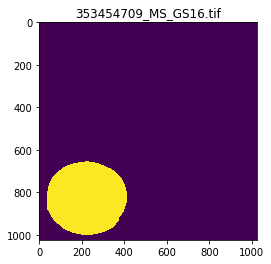

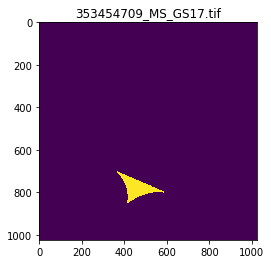

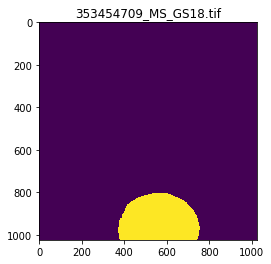

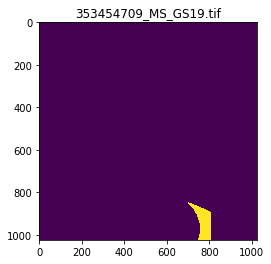

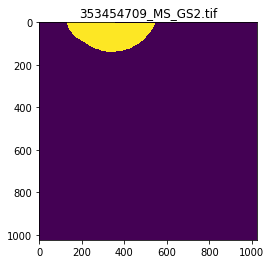

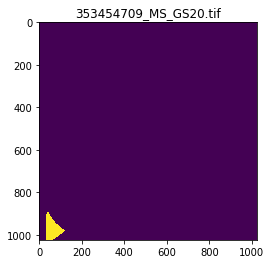

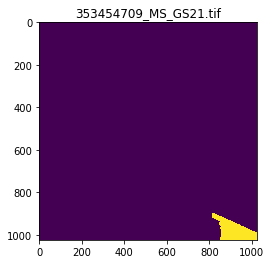

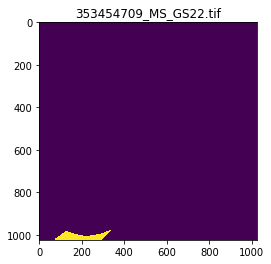

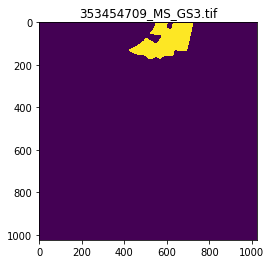

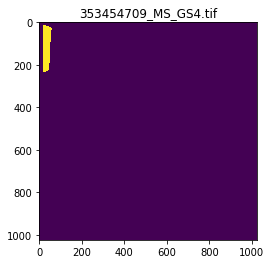

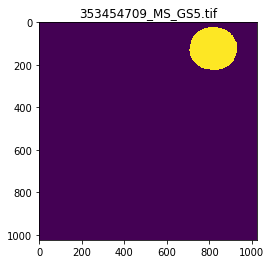

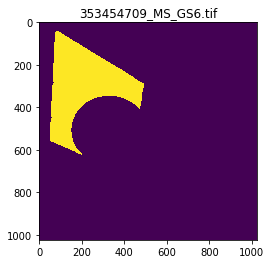

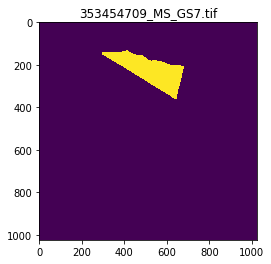

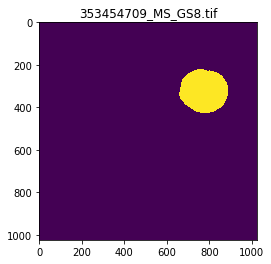

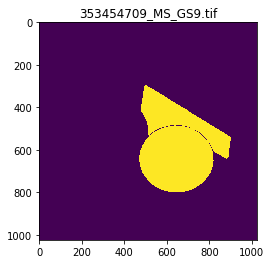

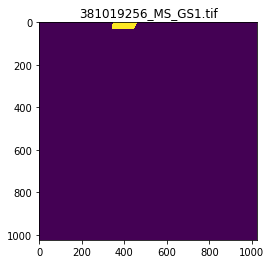

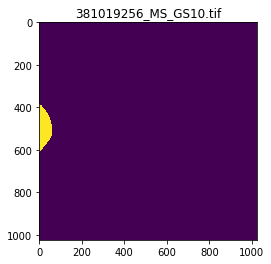

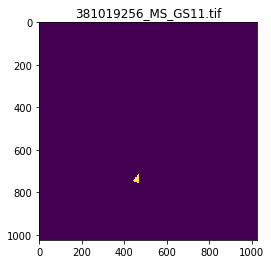

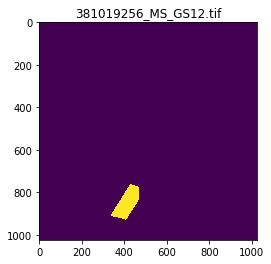

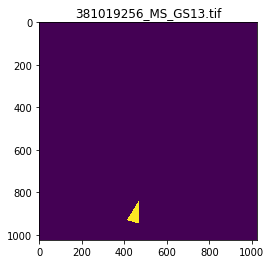

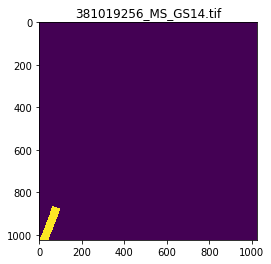

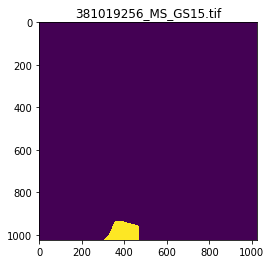

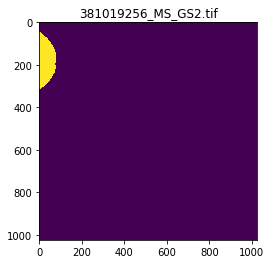

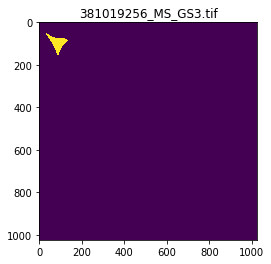

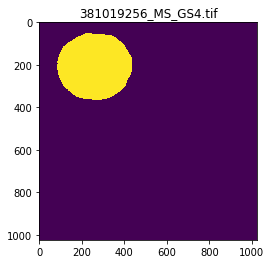

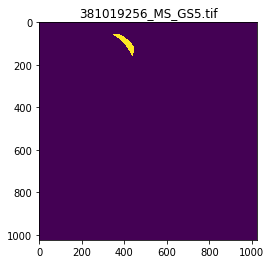

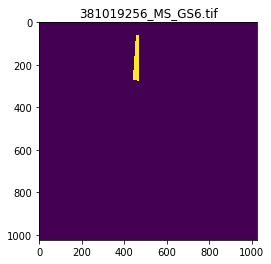

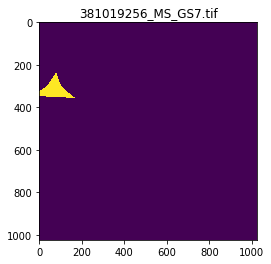

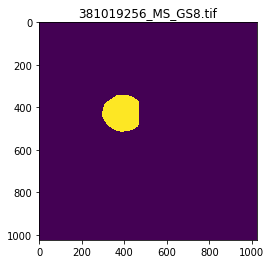

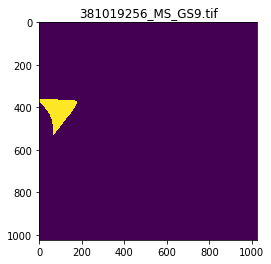

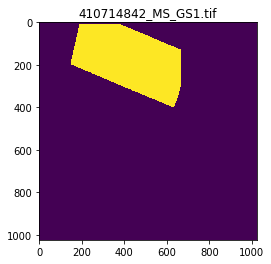

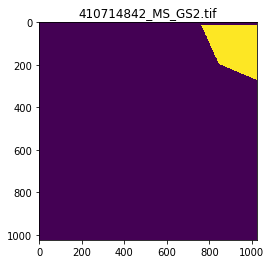

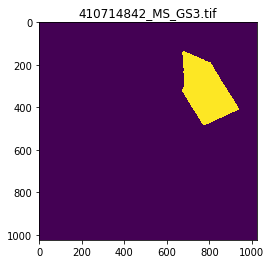

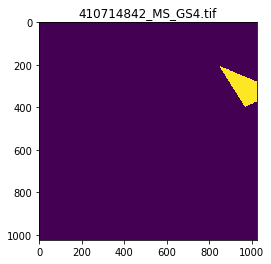

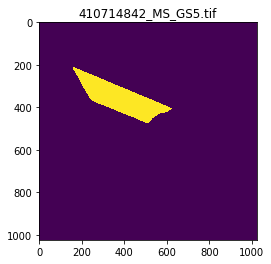

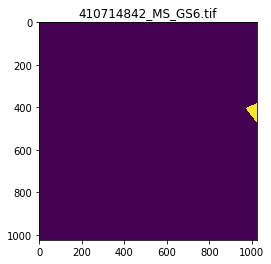

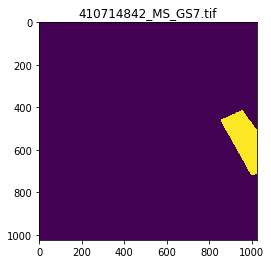

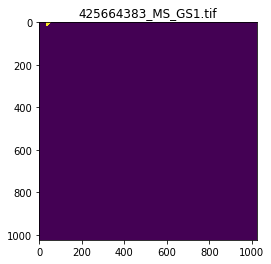

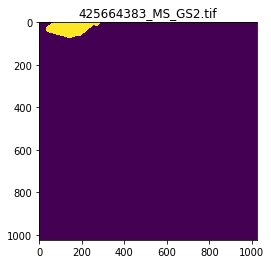

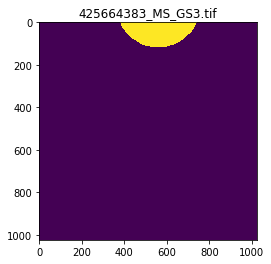

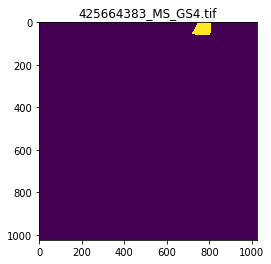

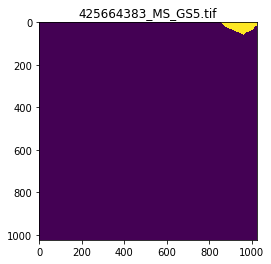

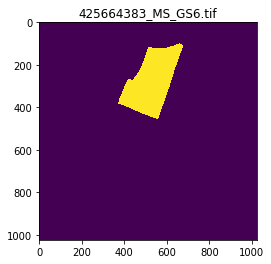

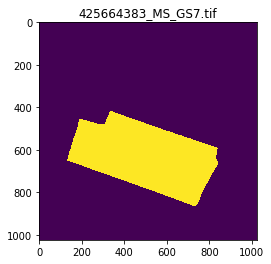

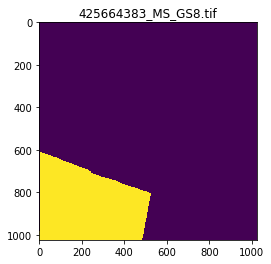

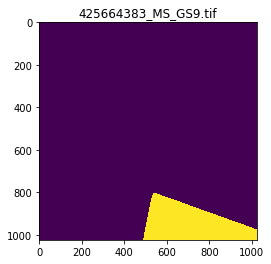

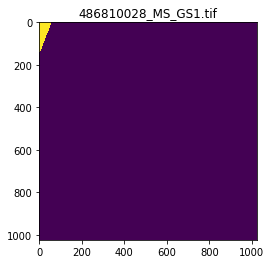

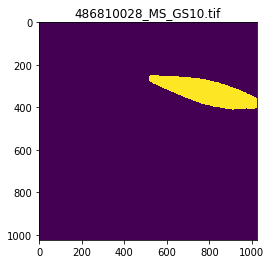

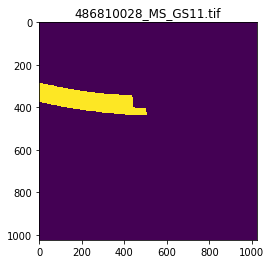

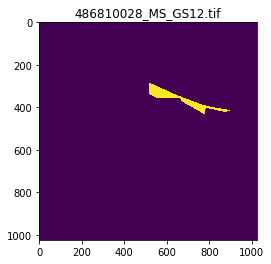

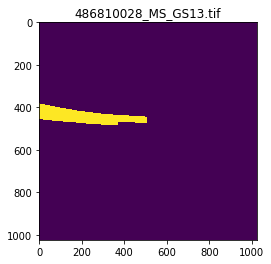

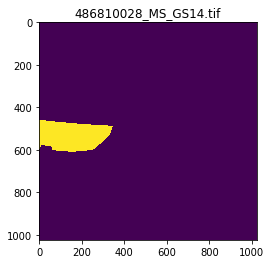

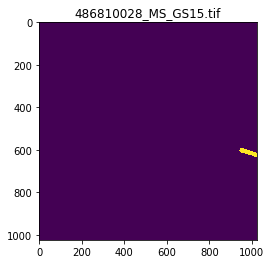

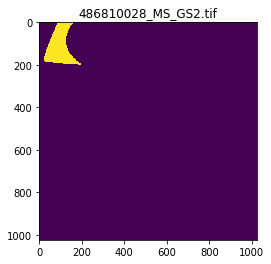

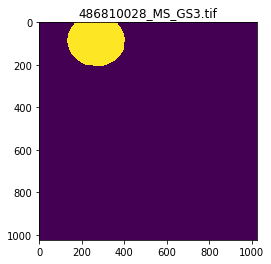

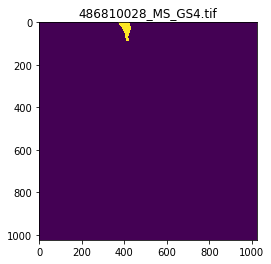

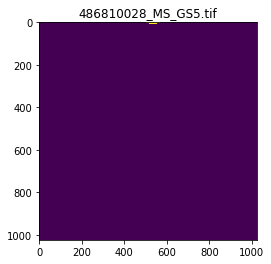

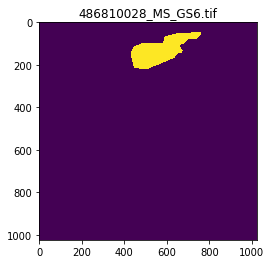

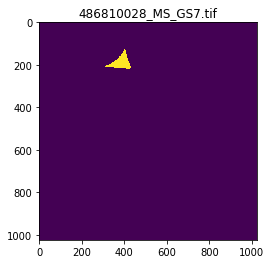

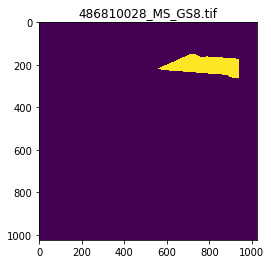

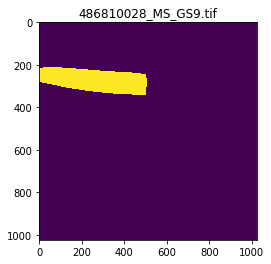

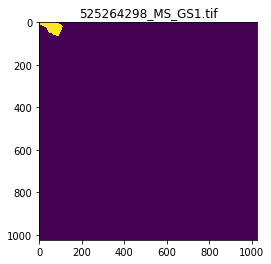

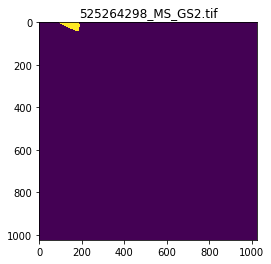

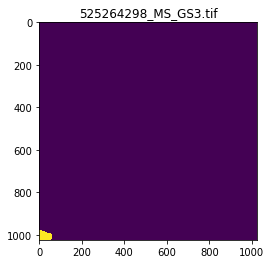

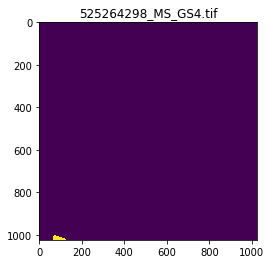

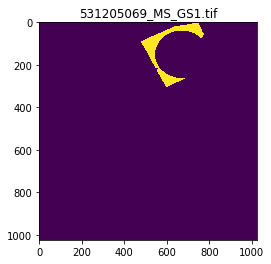

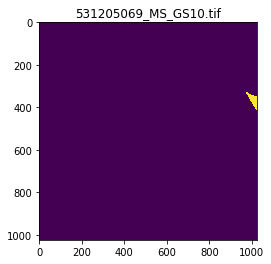

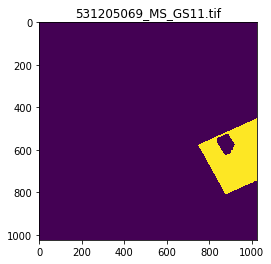

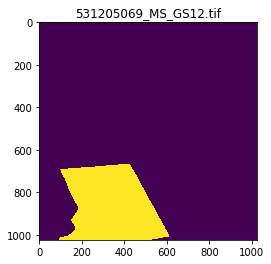

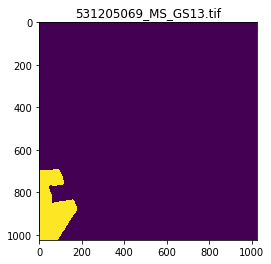

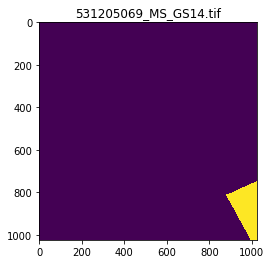

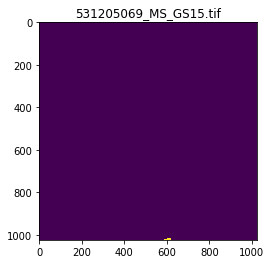

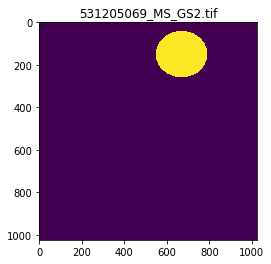

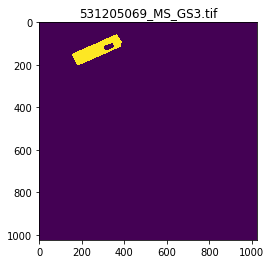

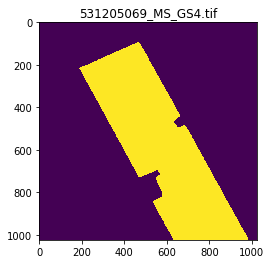

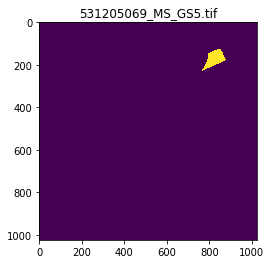

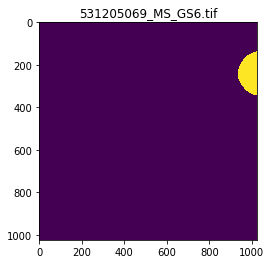

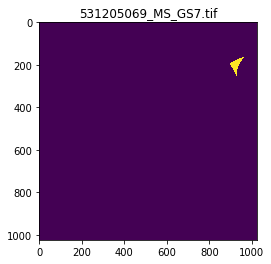

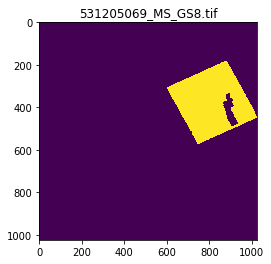

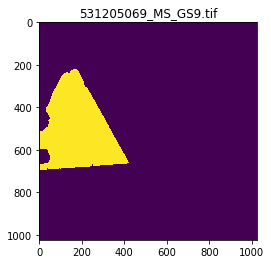

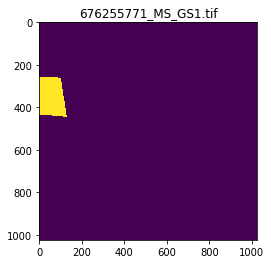

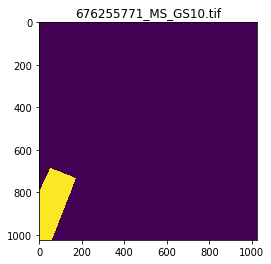

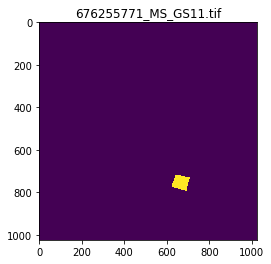

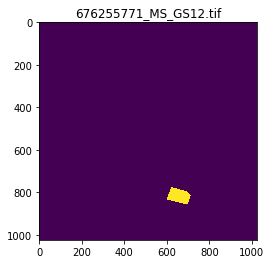

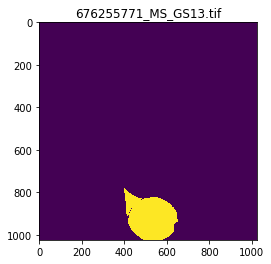

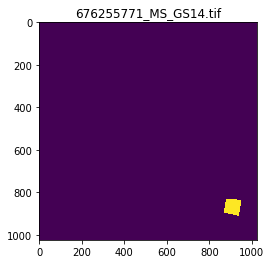

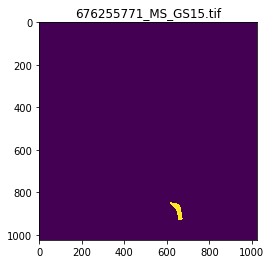

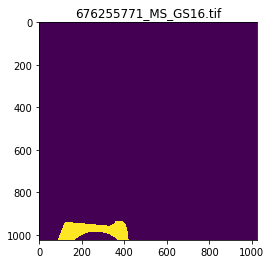

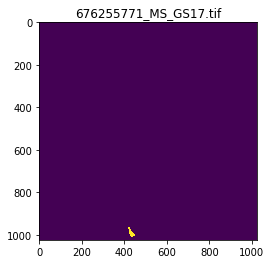

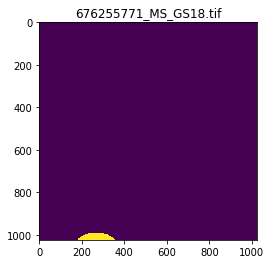

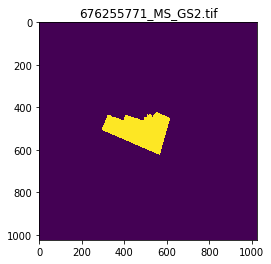

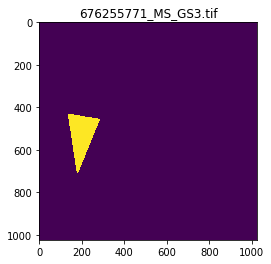

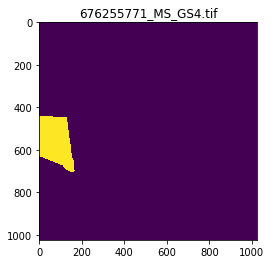

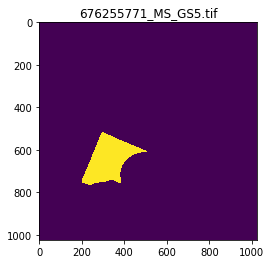

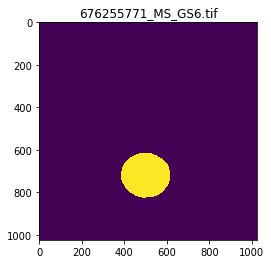

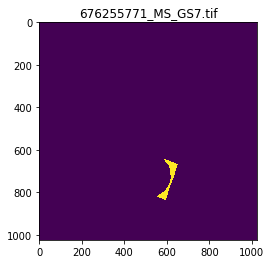

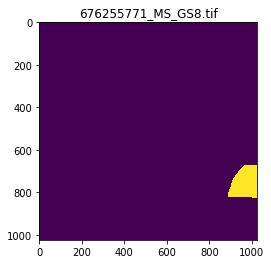

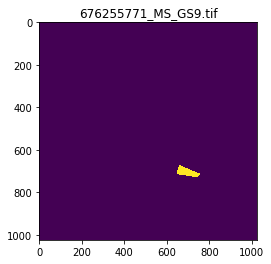

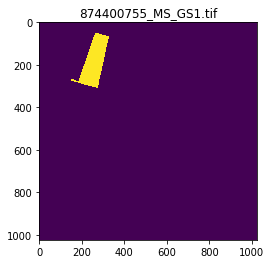

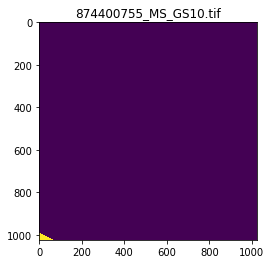

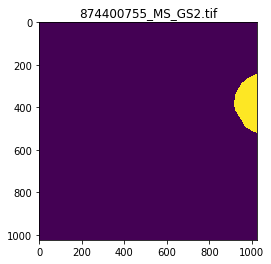

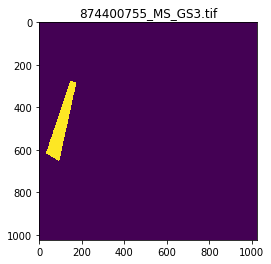

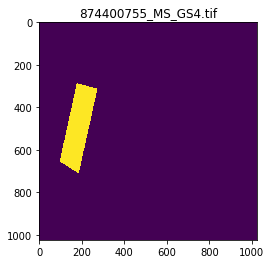

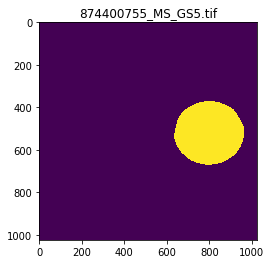

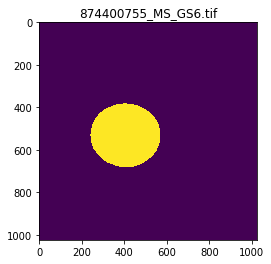

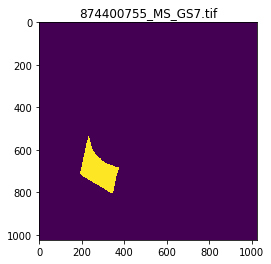

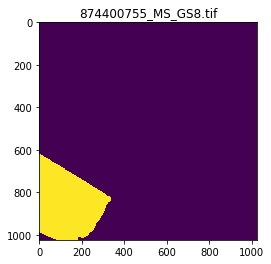

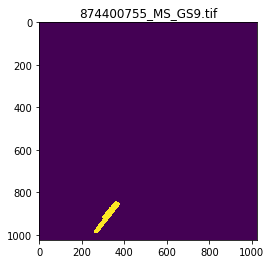

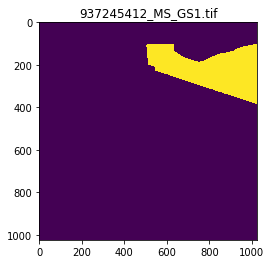

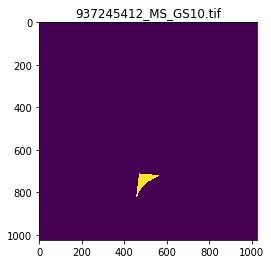

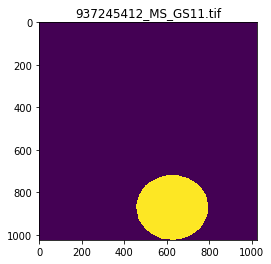

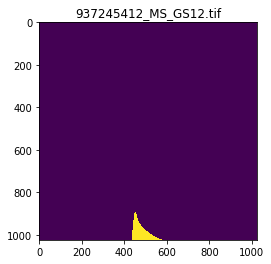

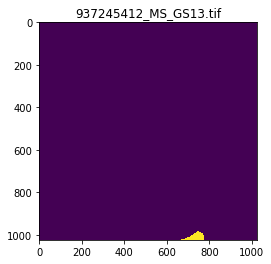

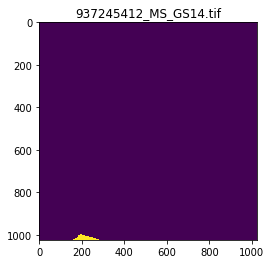

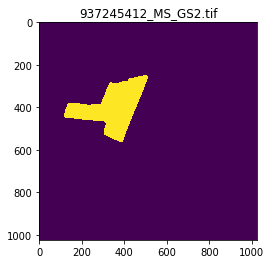

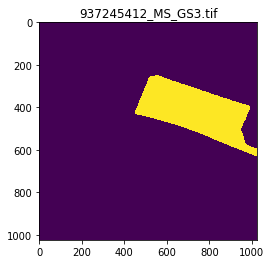

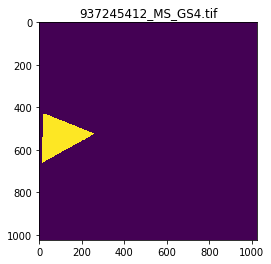

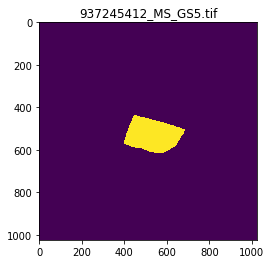

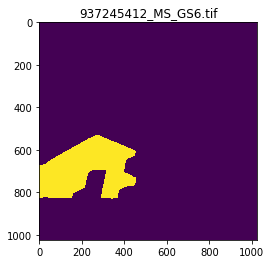

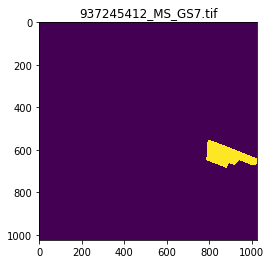

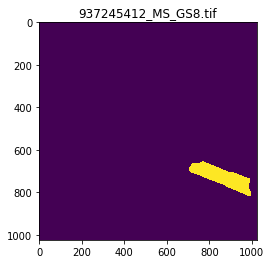

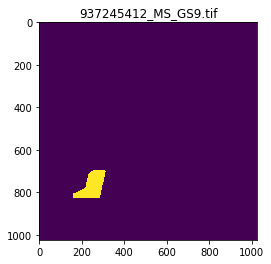

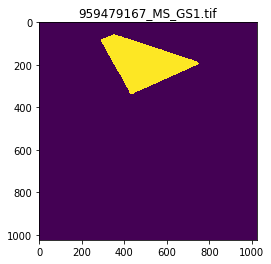

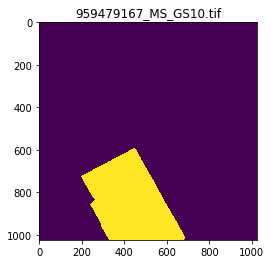

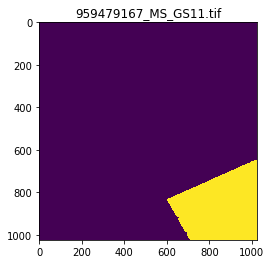

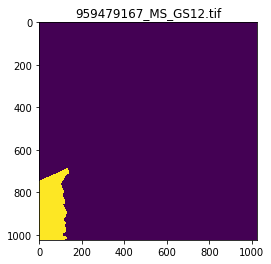

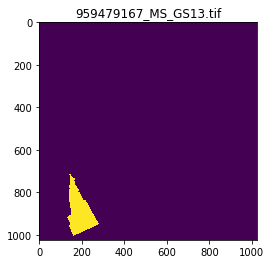

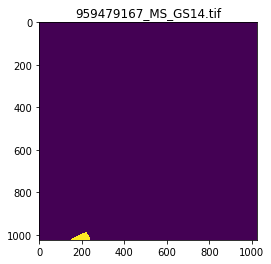

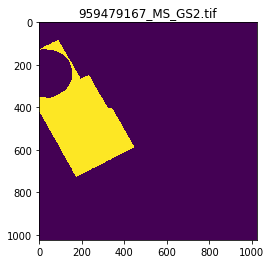

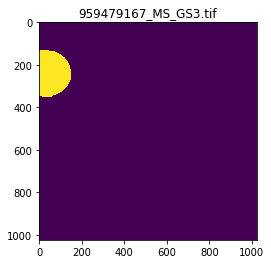

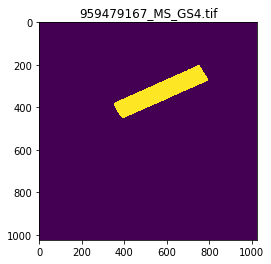

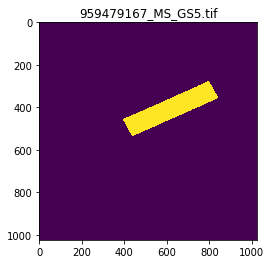

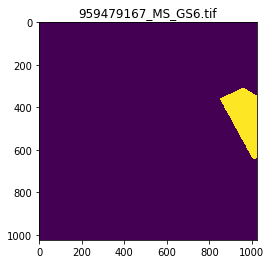

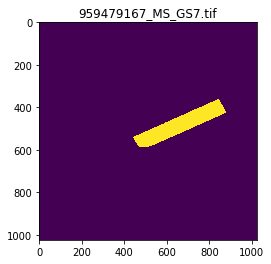

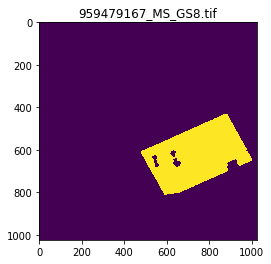

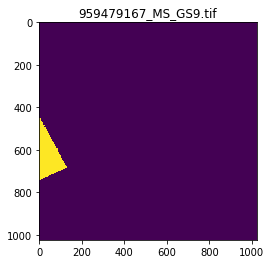

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
instances = sorted(next(os.walk(CONNECTED_COMP_DIR))[2])
for instance in instances:
    arr = skio.imread(os.path.join(CONNECTED_COMP_DIR,instance))
    plt.figure()
    plt.imshow(arr)
    print(instance)
    plt.title(instance)

In [24]:
preprocess()

(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024, 8)
(1024, 1024, 3) color_arr shape
(1024, 1024)


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2296, 2541)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2292, 2546)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2296, 2541)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2277, 2519)
  warnings.warn(str(e))


(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2296, 2541)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2292, 2546)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2296, 2541)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2277, 2519)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2277, 2519)
  warnings.warn(str(e))


(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2296, 2541)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2292, 2546)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2292, 2546)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2296, 2541)
  warnings.warn(str(e))


(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)


/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2277, 2519)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2292, 2546)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2277, 2519)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2277, 2519)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024) to (2292, 2546)
  warnings.warn(str(e))


(1024, 1024)
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/285397122_MS_GS1.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/285397122_MS_GS2.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/285397122_MS_GS3.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/285397122_MS_GS4.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/285397122_MS_GS5.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/285397122_MS_GS6.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/285397122_MS_GS7.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/285397122_MS_GS8.tif connecte

/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/410714842_MS_GS3.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/410714842_MS_GS4.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/410714842_MS_GS5.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/410714842_MS_GS6.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/410714842_MS_GS7.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/266400214_MS_GS1.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/266400214_MS_GS2.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/266400214_MS_GS3.tif connected comp prior to move
(1024

/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/874400755_MS_GS7.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/874400755_MS_GS8.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/874400755_MS_GS9.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/874400755_MS_GS10.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/121278532_MS_GS1.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/121278532_MS_GS2.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/353454709_MS_GS1.tif connected comp prior to move
(1024, 1024)
/tana-crunch/waves/cropmask/data/raw/wv2/connected_comp_labels/353454709_MS_GS2.tif connected comp prior to move
(102

In [ ]:
def train_test_split(train_dir, test_dir, kprop):
    """Takes a sample of folder ids and copies them to a test directory
    from a directory with all folder ids. Each sample folder contains an 
    images and corresponding masks folder."""

    remove_dir_folders(test_dir)
    sample_list = next(os.walk(train_dir))[1]
    k = round(kprop*len(sample_list))
    test_list = random.sample(sample_list,k)
    for test_sample in test_list:
        shutil.copytree(os.path.join(train_dir,test_sample),os.path.join(test_dir,test_sample))
    train_list = list(set(next(os.walk(train_dir))[1]) - set(test_list))
    train_df = pd.DataFrame({'train': train_list})
    test_df = pd.DataFrame({'test': test_list})
    train_df.to_csv(os.path.join(RESULTS_DIR, 'train_ids.csv'))
    test_df.to_csv(os.path.join(RESULTS_DIR, 'test_ids.csv'))

train_test_split(TRAIN_DIR, TEST_DIR, .1)
print('preprocessing complete, ready to run model.')

Ways to visualize images. percentile rescale function does ok but washes out some images.

In [131]:
from skimage import exposure
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

scenes = os.listdir(OUT_WV2_DIR)
def percentile_rescale(arr):
    '''
    Rescales and applies other exposure functions to improve image vis. 
    http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.rescale_intensity
    '''
    rescaled_arr = np.zeros_like(arr)
    for i in range(0,arr.shape[-1]):
        val_range = (np.percentile(arr[:,:,i], 1), np.percentile(arr[:,:,i], 99))
        rescaled_channel = exposure.rescale_intensity(arr[:,:,i], val_range)
        rescaled_arr[:,:,i] = rescaled_channel
#     rescaled_arr= exposure.adjust_gamma(rescaled_arr, gamma=1) #adjust from 1 either way
#     rescaled_arr= exposure.adjust_sigmoid(rescaled_arr, cutoff=.50) #adjust from .5 either way 
    return rescaled_arr
# commented out method alone works best for images 04 and 05. above function works best for image 08
# arr= exposure.adjust_gamma(arr, gamma=.23)
# arr= exposure.adjust_sigmoid(arr, cutoff=.28)
# arr = exposure.equalize_adapthist(arr, clip_limit=.004)

for scene in scenes:
    arr = skio.imread(os.path.join(OUT_WV2_DIR,scene))
    red = arr[:,:,4]/arr[:,:,4].max()
    blue = arr[:,:,1]/arr[:,:,1].max()
    green = arr[:,:,2]/arr[:,:,2].max()
    color_arr = np.dstack((red, green, blue))
    color_arr[color_arr <= 0]=0
    plt.figure()
    skio.imshow(percentile_rescale(color_arr), cmap='brg')

/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (1024, 1024, 3) to (2292, 2546, 3)
  warnings.warn(str(e))


IndexError: index 4 is out of bounds for axis 2 with size 3

For some reason the 8th growing season has much much lower range for all channels, and lower over all values for red compared to other bands. Keeping this hear in case it becomes an issue later with model training. This scene could just be more photosynthetically active overall??? Normalizing not just by max but also by mean makes this look a little more like true color with fallow fields and active center pivots.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

matplotlib.rcParams['font.size'] = 8

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.
    
    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

# Load an example image
arr = skio.imread(os.path.join(REORDER_DIR,'08_MS_GS.tif'))

red = arr[:,:,0]/arr[:,:,0].max()
blue = arr[:,:,1]/arr[:,:,1].max()
green = arr[:,:,2]/arr[:,:,2].max()
color_arr = np.dstack((red, blue, green))
color_arr[color_arr <= 0]=0
red_gam= exposure.adjust_gamma(red, gamma=.45)
green_gam = exposure.adjust_gamma(green, gamma=.45)
blue_gam = exposure.adjust_gamma(blue, gamma=.45)
# arr= exposure.adjust_sigmoid(arr, cutoff=.38)
# arr = exposure.equalize_adapthist(arr, clip_limit=.004)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(red, axes[:, 0])
ax_img.set_title('Red Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(red_gam, axes[:, 1])
ax_img.set_title('Red Gamma correction')

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(green, axes[:, 0])
ax_img.set_title('Green Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(green_gam, axes[:, 1])
ax_img.set_title('Green Gamma correction')

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(blue, axes[:, 0])
ax_img.set_title('Blue Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(blue_gam, axes[:, 1])
ax_img.set_title('Blue Gamma correction')

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()